# Coarse-graining SST/SSS
Coarse graining the tracer fields to varying resolutions to determine the effect of scales on the HTA

## Table Of Contents: <a class="anchor" id="top"></a>

* [10km](#first-bullet)
* [100km](#second-bullet)
* [Compute the HTA of the varying resolutions](#third-bullet)

> Code borrowed from [Paige's nb](https://github.com/ocean-transport/cesm-air-sea/blob/fix-advection/clean_codes/Filter_scalarField_fixedLength_POP.ipynb)

In [41]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [44]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.175e08f0e6a2438499008988393260b2/status,


In [116]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import json
import fsspec
import gcsfs
import gcm_filters
import pop_tools

In [4]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()
#workaround from Julius to make gradient func work quicker
ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU', 'KMT', 'TAREA',
                                                         'HUS', 'HTE','HTN', 'HUW', 'time']])

## Create mask

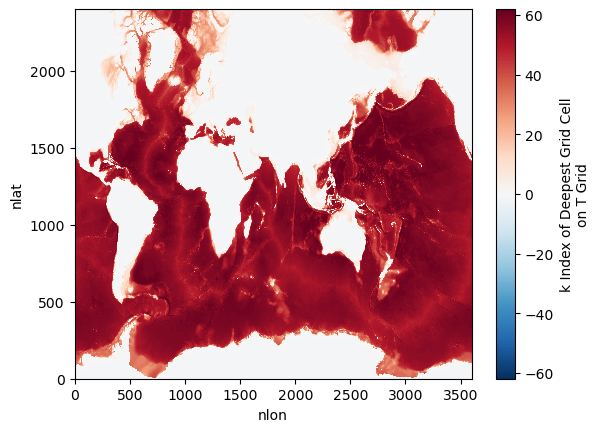

In [6]:
ds_drop.KMT.plot()

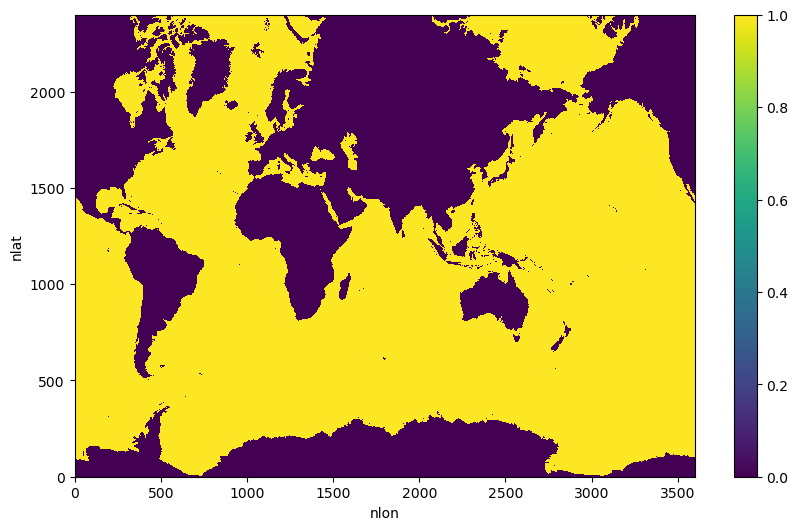

In [5]:
gcm_filters.required_grid_vars(gcm_filters.GridType.TRIPOLAR_POP_WITH_LAND)
wet_mask = xr.where(ds_drop['KMT']>0, 1, 0)
wet_mask.plot(figsize=(10,6), cbar_kwargs={'label': ''});

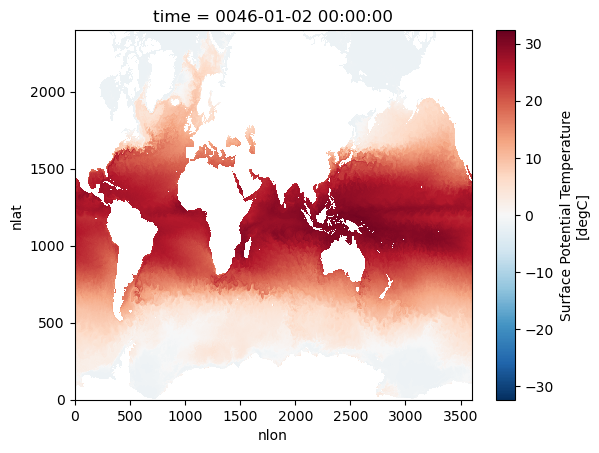

In [9]:
ds_drop.SST.where(wet_mask)[0].plot();

In [6]:
area = ds_drop.TAREA  # in cm^2
dxe = ds_drop.HUS  # x-spacing centered at eastern T-cell edge in cm
dye = ds_drop.HTE  # y-spacing centered at eastern T-cell edge in cm
dxn = ds_drop.HTN  # x-spacing centered at northern T-cell edge in cm
dyn = ds_drop.HUW  # y-spacing centered at northern T-cell edge in cm

In [7]:
# Didn't need .values for each direction previously, but I seem to now (otherwise I get NaN)
dx_min_POP = min(dxe.where(wet_mask).min().values, dye.where(wet_mask).min().values, 
                 dxn.where(wet_mask).min().values, dyn.where(wet_mask).min().values)
dx_min_POP 

array(224578.30434359)

# 1) 10km <a class='anchor' id='first-bullet'></a>

In [8]:
specs_10km = {'filter_scale': 1000000, # 1km filter scale (written in cm to match model output)
             'filter_shape': gcm_filters.FilterShape.GAUSSIAN, 'dx_min': dx_min_POP}

In [9]:
filter_tripolar_pop_with_land_10km = gcm_filters.Filter(**specs_10km, 
                                                   grid_type=gcm_filters.GridType.TRIPOLAR_POP_WITH_LAND,
                                                   grid_vars={'wet_mask': wet_mask, 'dxe': dxe, 'dye': dye, 
                                                              'dxn': dxn, 'dyn': dyn, 'tarea': area})
filter_tripolar_pop_with_land_10km

Filter(filter_scale=1000000, dx_min=array(224578.30434359), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=5, grid_type=<GridType.TRIPOLAR_POP_WITH_LAND: 9>)

In [10]:
filtered10km_sst = filter_tripolar_pop_with_land_10km.apply(ds_drop.SST, dims=['nlat', 'nlon'])
filtered10km_sss = filter_tripolar_pop_with_land_10km.apply(ds_drop.SSS, dims=['nlat', 'nlon'])

# 2) 100km <a class='anchor' id='second-bullet'></a>

In [11]:
specs_100km = {'filter_scale': 10000000, # 100km filter scale (written in cm to match model output)
         'filter_shape': gcm_filters.FilterShape.GAUSSIAN, 'dx_min': dx_min_POP}

In [12]:
filter_tripolar_pop_with_land_100km = gcm_filters.Filter(**specs_100km, 
                                                   grid_type=gcm_filters.GridType.TRIPOLAR_POP_WITH_LAND,
                                                   grid_vars={'wet_mask': wet_mask, 'dxe': dxe, 'dye': dye, 
                                                              'dxn': dxn, 'dyn': dyn, 'tarea': area})
filter_tripolar_pop_with_land_100km

Filter(filter_scale=10000000, dx_min=array(224578.30434359), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=49, grid_type=<GridType.TRIPOLAR_POP_WITH_LAND: 9>)

In [13]:
filtered100km_sst = filter_tripolar_pop_with_land_100km.apply(ds_drop.SST, dims=['nlat', 'nlon'])
filtered100km_sss = filter_tripolar_pop_with_land_100km.apply(ds_drop.SSS, dims=['nlat', 'nlon'])

## Plot the 3 different resolutions

In [14]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.925ff77566f443e883fa938ed4b417e0/status,


In [47]:
sst_10km = filtered10km_sst[0].compute()
sss_10km = filtered10km_sss[0].compute()

sst_100km = filtered100km_sst[0].compute()
sss_100km = filtered100km_sss[0].compute()

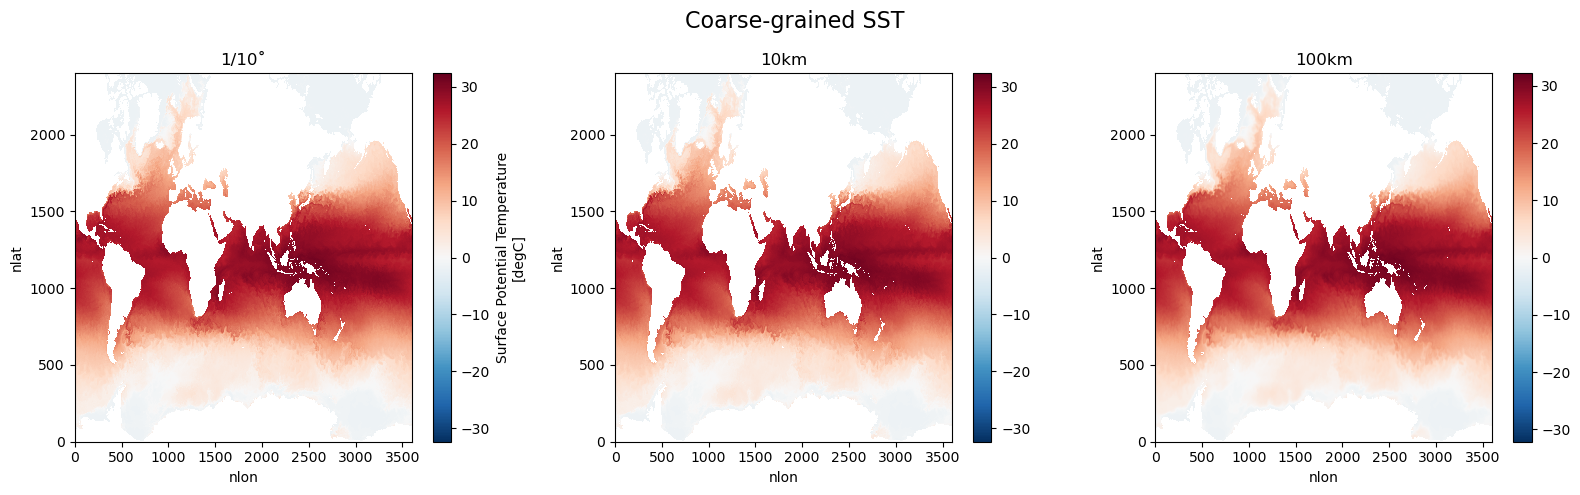

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

ds_drop.SST[0].plot(ax=ax[0])
ax[0].set_title('1/10˚')

sst_10km.plot(ax=ax[1])
ax[1].set_title('10km')

sst_100km.plot(ax=ax[2])
ax[2].set_title('100km')

plt.suptitle('Coarse-grained SST', fontsize=16)
plt.tight_layout();

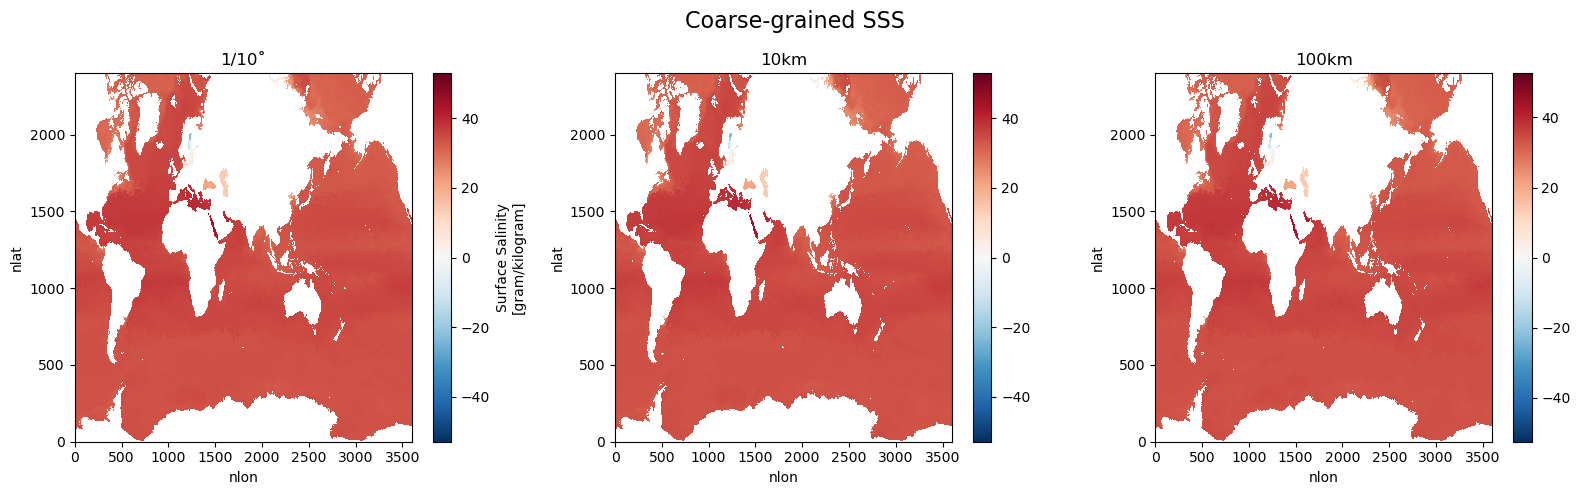

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

ds_drop.SSS[0].plot(ax=ax[0])
ax[0].set_title('1/10˚')

sss_10km.plot(ax=ax[1])
ax[1].set_title('10km')

sss_100km.plot(ax=ax[2])
ax[2].set_title('100km')

plt.suptitle('Coarse-grained SSS', fontsize=16)
plt.tight_layout();

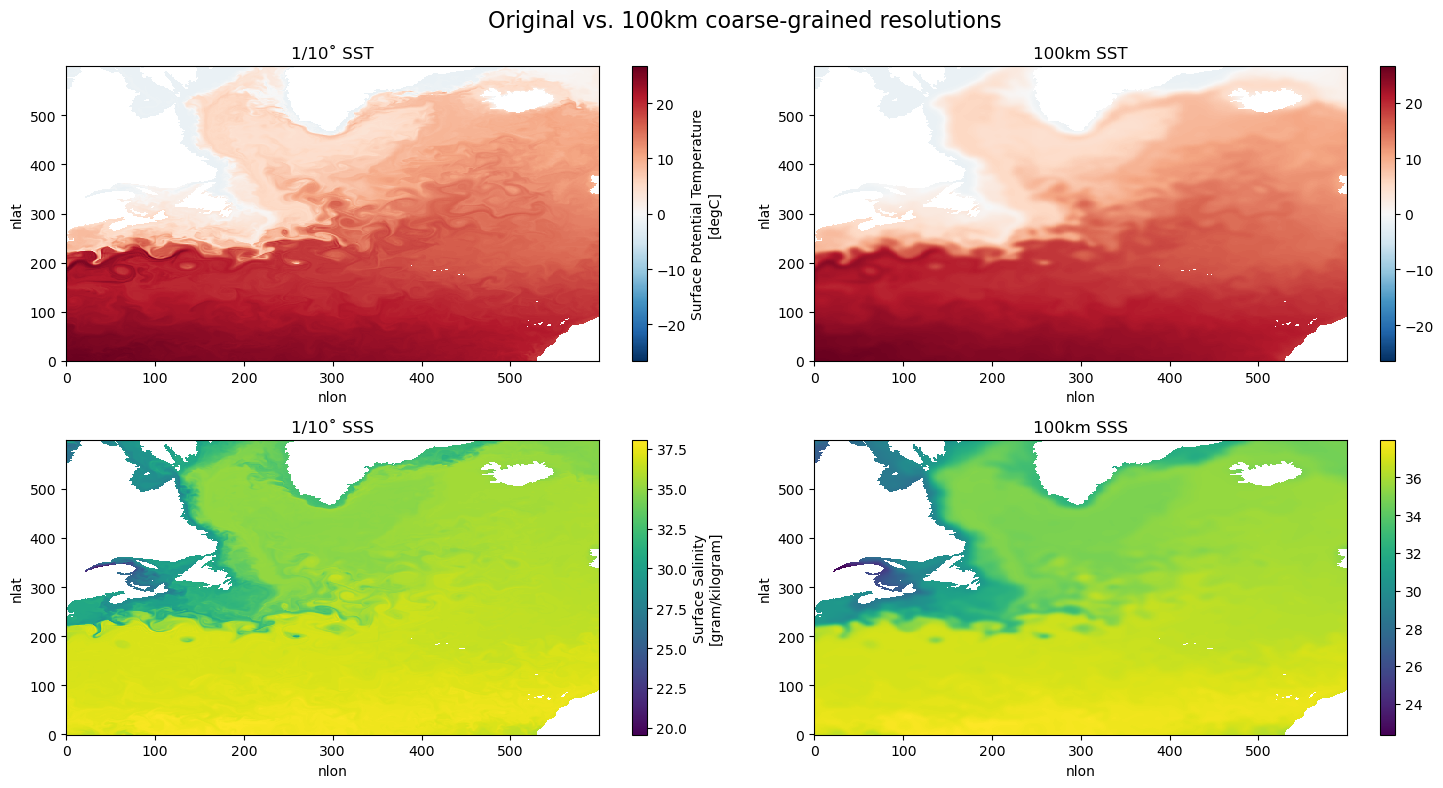

In [55]:
fig, ax = plt.subplots(2,2, figsize=(15,8))

ds_drop.SST[0].isel(nlon=slice(400,1000), nlat=slice(1400, 2000)).plot(ax=ax[0,0])
ax[0,0].set_title('1/10˚ SST')

sst_100km.isel(nlon=slice(400,1000), nlat=slice(1400, 2000)).plot(ax=ax[0,1])
ax[0,1].set_title('100km SST')

ds_drop.SSS[0].isel(nlon=slice(400,1000), nlat=slice(1400, 2000)).plot(ax=ax[1,0])
ax[1,0].set_title('1/10˚ SSS')

sss_100km.isel(nlon=slice(400,1000), nlat=slice(1400, 2000)).plot(ax=ax[1,1])
ax[1,1].set_title('100km SSS')

plt.suptitle('Original vs. 100km coarse-grained resolutions', fontsize=16)
plt.tight_layout();

[Back to top](#top)

## Save & upload monthly climatology of TA <a class='anchor' id='saving-data'></a>

In [46]:
ds = xr.merge([filtered10km_sst.rename('SST_10km'), filtered100km_sst.rename('SST_100km'),
               filtered10km_sss.rename('SSS_10km'), filtered100km_sss.rename('SSS_100km')])

time_slice = dict(time=slice(0, 365)) #first year

ds_sel = ds.isel(**time_slice)

In [48]:
ds_sel.nbytes/1e9

51.14880292

In [43]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [47]:
#saving monthly climatology ta
gcsmap_filters = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/filtered_res.zarr')
ds_sel.to_zarr(gcsmap_filters, mode='w')

[Back to top](#top)